In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import timeit

import os
import sys
root_path = os.getcwd() + "/scripts/personal/rick"
sys.path.append(str(root_path))

from prime_Functions_Andrew import *
from prime_Functions_quditV2 import *
np.set_printoptions(linewidth=200)

In [ ]:
#############
### setup ###
#############

# import Hamiltonian
# P - Collection of Pauli Operators
# cc - list of coefficients
#P,cc = read_luca_test_2("./Hamiltonians/"+"Hams"+"/"+"Open"+"/"+ "full_D3_rev" +".txt",dims=3)
P,cc = read_luca_test_2("./Hamiltonians/"+"Hams"+"/"+"Open"+"/"+ "full_D3_rev" +".txt",dims=[3,2,2,2,2])


# sort the Pauli operators to make computations easier and faster
# pauli_block_sizes - list of which pauli operators are hermitian (1) or have a hermitian conjugate (2)
P,cc,pauli_block_sizes = sort_hamiltonian(P,cc)

## experiment parameters
# general_commutation - allow for non-bitwise commutation in the cliques
# allocation_mode - how to allocate measurements
#    - 'set': according to the estimated covariance matrix
#    - 'rand': randomly (all cliques equal chance)
general_commutation = True
allocation_mode = 'set'

## Monte-Carlo Parameters
# N_chain - how many chains are used to calculate the covariances
# N_mcmc - initial length of the monte-carlo chain
# N_mcmc_max - cut-off length for monte-carlo chain
# mcmc_shot_scale - how strongly N_mcmc and N_mcmc_max should scale with the shot number
N_chain = 8
N_mcmc = 500
N_mcmc_max = 2001
mcmc_shot_scale = 1/10000

# For this test only: true state
#psi = ground_state(P,cc)
psi = ground_state(P,cc)
psi = np.around(psi,1)
psi = psi/np.linalg.norm(psi)

p_noise = 0.01


########################
### Start Simulation ###
########################


'''1. Calculate an initial list of cliques to measure before the first update of the covariance matrix '''
# initial number of shots, when nothing is known
shots_init = 10
print(shots_init)

# function: bfq_experiment_initial
# inputs:
# - P - set of Paulis 
# - cc - list of coefficients
# - pauli_block_list - take from sort_hamiltonian fuction
# - shots_init - how many shots you want to allocate without updating the covariance estimation
# - general_commutation - choice of general or only bitwise commutation
# - allocation_mode - whether to allocate according to the covariance matrix ('set') or randomly ('rand')
# - N_chain, N_mcmc, N_mcmc_max, mcmc_shot_scale - parameter to tune speed vs accuracy of the monte-carlo integration used for the covariance estimation
# outputs:
# xxx - list of cliques to measure - example: [[1,2,3],[2,3,4],[1,3,4,5]] (includes cliques [1,2,3] with Paulis 1,2,3 etc)
# circuit_list - list of circuits to diagonalize the cliques in xxx - circuit C formated like in AEQuO, access with C.print()
# algorithm_variables - everything that needs to be carried over for the algorithm to run (usually no need to interact with)

xxx,circuit_list,algorithm_variables =  bfq_experiment_initial(P,cc,pauli_block_sizes,shots_init,general_commutation = general_commutation, 
                                                               allocation_mode = allocation_mode, N_chain = N_chain, N_mcmc = N_mcmc,
                                                               N_mcmc_max = N_mcmc_max, mcmc_shot_scale = mcmc_shot_scale)

'''2. Measure the specifided cliques in xxx with the circuits in circuit_list '''
# For testing: Generate some results for the cliques from the true state 
rr = example_results(psi,xxx,algorithm_variables)
rr = noise_adder(rr,p_noise,P.dims)

'''3. Input the measurement results and calculate new cliques to measure '''
# shots that will now be added
shots = 100 
print(shots)

# function: bfq_experiment
# inputs:
# - xxx - list of cliques from previous step
# - rr - list of measurement results - example: [np.array([2.,2.,0]),np.array([1.,2.,0])]
#        Important: order of xxx and rr have to match
# - algorithm_variables - carry over from before 
# Outputs:
# xxx - list of cliques to measure - example: [[1,2,3],[2,3,4],[1,3,4,5]] (includes cliques [1,2,3] with Paulis 1,2,3 etc)
# circuit_list - list of circuits to diagonalize the cliques in xxx - circuit C formated like in AEQuO, access with C.print()
# algorithm_variables - everything that needs to be carried over for the algorithm to run (usually no need to interact with)

xxx,circuit_list,algorithm_variables = bfq_experiment(xxx,rr,shots,algorithm_variables)

'''4. Repeat steps 2. and 3. as much as you like (shot numbers can be varried as desired) '''
# Example of repeating it twice with exponentially increasing shot numbers
rr = example_results(psi,xxx,algorithm_variables)
rr = noise_adder(rr,p_noise,P.dims)
shots = 1000
print(shots)

xxx,circuit_list,algorithm_variables = bfq_experiment(xxx,rr,shots,algorithm_variables)
rr = example_results(psi,xxx,algorithm_variables)
rr = noise_adder(rr,p_noise,P.dims)

shots = 10000
print(shots)

xxx,circuit_list,algorithm_variables = bfq_experiment(xxx,rr,shots,algorithm_variables)
rr = example_results(psi,xxx,algorithm_variables)
rr = noise_adder(rr,p_noise,P.dims)

'''5. Calibration measurements of stabalizer states'''
# Perform calibration measurements (one for each circuit)
# By seeing if a stablelizer for a certain cirucuit is left unchanged (and how often) we can get a rough estimate for 
# the error rate of the circuit
# We than use these measurements to make an estimate of the physical noise affecting the simulation.
# For an easy demonstration we just use the |0..0> state

# states to be measured for the relevant circuits
ss,circuit_list_total,state_preparation_circuits = diagnosis_states(algorithm_variables,mode='Null')
# measurement results of these states (here done by using the noise probability p_noise)
rr_cal = example_results_calibration(ss,circuit_list_total,algorithm_variables,mode='Null',p_noise=p_noise)
# let the computer check and compare the results, compiling them in a way most useful for the code
X_calibration = error_calibration(ss,rr_cal,algorithm_variables,mode='Null')



'''6. Once measurement budget has been used up, calculate mean and error '''
# last step should have been a measurement step so that the algorithm doesn't expect more cliques to be measured

# function: bfq_estimation
# inputs:
# - xxx - last group of cliques that have been measured
# - rr - measurement results that correspond to xxx
# - algorithm_variables - everything that needs to be carried over for the algorithm to run (usually no need to interact with)
# outputs:
# - mean - estimate for the mean of the Hamiltonian/observable
# - error - standard deviation for the estimated mean
# - algorithm_variables - everything that needs to be carried over for the algorithm to run (usually no need to interact with)

mean, error, algorithm_variables = bfq_estimation(xxx,rr,algorithm_variables)

# Estimate the physical error in the system based on the number of wrong stabalizer measurements encoded in X_calibration
error_correction = bfq_error_correction(X_calibration,algorithm_variables)

# True values for comparison:
# S - how many times each Pauli-string has been measured and how often two have been measured together
S = algorithm_variables[4]
print('True mean:',Hamiltonian_Mean(P,cc,psi).real)
print('True error:',np.sqrt(np.sum(scale_variances(variance_graph(P,cc,psi),S).adj)).real)
print()
# Estimated results:
print('Est. mean:',mean)
print('Est. var:',error**2)
print('Est. error (uncorrected):',error)
#print('var correction:',error_correction)
print('Error total:',np.sqrt(error**2 + error_correction))


In [ ]:
# Examples for specific quantities:

print('First 3 elements of the last xxx',xxx[:3])
print()
print('First 3 elements of the last rr',rr[:3])
print()
print('First 3 elements of the last circuit_list:')
for i in range(3):
    C = circuit_list[i]
    C.print()
    print()

# Experiment Proposal

Use the open plaquette Hamiltonian with $d=3$, $m=-50$, $\Omega = 5$ und $\beta = 0.05$. For the state we use $|\psi\rangle = |\uparrow \downarrow \uparrow \downarrow \rangle \left( \frac{|0\rangle + |1\rangle}{2} \right)$ which has a fidality with the ground state of $F_{GS} = 99\%$ and is created through the circuit:

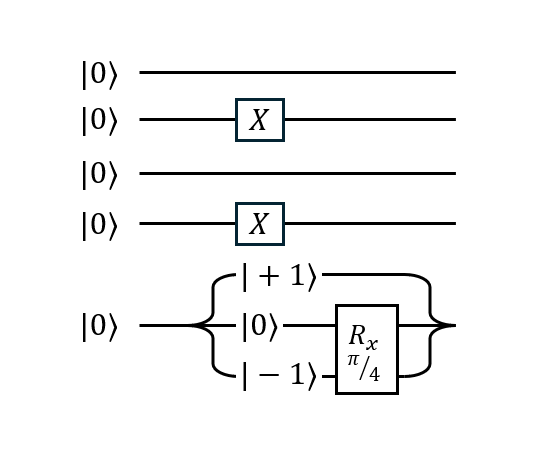

We perform the experiment for both general and bitwise commutation, adaptively for roughly 100k shots.\
For update step we perform an equal number of calibration measurements.\
Record the evolution of the mean, error and error correction.

Possible Figures:
- Fig.1: Absolute distance of the mean from the correct value. Through noise, it won't reach the real value, but the correction term for the error accounts for that
- Fig.2: Relative error, corrected via the callibration measurements through the course of the experiment. Relative error stops following the 1/M asymptote once the physical error becomes to large -> Means of classifying the actual physical error for different settings
- Fig.3: Comparing the necessary error correction induced by the calibration measurements for bitwise and general commutaton and different Hamiltonians and states


In [ ]:
# Examples of Fig.1 and Fig.2 averaged over 25 runs

results = np.load("InnsbruckD3ResultsV5N102401p_noise0.005.npy")

cm = 1/2.54
shots = 12801
part_func = weighted_vertex_covering_maximal_cliques
full_simulation = True
intermediate_results_list = [6,12,25,50,100,200,400,800,1600,3200,6400,12800,25600,51200,102400]
allocation_mode = 'set'

## Monte-Carlo
N = 500
N_max = 2001
mcmc_shot_scale = 0

## analysis
repeats = 40
p_noise = 0.005

## Hamiltonian and state
P,cc = read_luca_test_2("./Hamiltonians/"+"Hams"+"/"+"Open"+"/"+ "full_D3_rev" +".txt",dims=[3,2,2,2,2])
P,cc,pauli_block_sizes = sort_hamiltonian(P,cc)
p,q = P.paulis(),P.qudits()
psi = ground_state(P,cc)
psi = np.around(psi,1)
psi = psi/np.linalg.norm(psi)
vg = variance_graph(P,cc,psi)

H_mean = Hamiltonian_Mean(P,cc,psi).real


## Result Plots
n_plot = [0,2]
settings = ['GC + adaptive', 'GC + non-adaptive', 'BC + adaptive', 'BC + non-adaptive','Andrew','True Covariance']
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(23*cm,11*cm))

x_dat = intermediate_results_list
y_dat = np.zeros((6,len(intermediate_results_list)))
y_err_dat = np.zeros((6,len(intermediate_results_list)))




for i in n_plot: 
    for j in range(len(intermediate_results_list)): 
        y_dat[i,j] = np.mean(np.abs(results[:,j,i,0] - H_mean))
        y_err_dat[i,j] = np.sqrt(np.mean(results[:,j,i,1]**2 + results[:,j,i,3]))

        
for i in n_plot:
    ax[0].errorbar(np.array(x_dat[:])+(i/20 * np.array(x_dat[:])), y_dat[i,0:], yerr=y_err_dat[i,0:], fmt='o',ecolor='k',
                 capsize=1,capthick=0.75,markersize=5,elinewidth=0.75,label=settings[i])
    
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$|\widetilde{O} - \langle \hat{O} \rangle|$',fontsize=14)
ax[0].set_xlabel(r'shots $M$',fontsize=14)
ax[0].set_title('Estimated Mean',fontsize=16)
ax[0].plot([x_dat[0],x_dat[-1]],[0,0],'k--')
#ax[0].legend()
ax[0].set_ylim(-1,10)


for i in n_plot: 
    for j in range(len(intermediate_results_list)): 
        #y_dat[i,j] = np.mean((results[:,j,i,1]**2 + results[:,j,i,3]) * intermediate_results_list[j]/ (H_mean)**2) 
        y_dat[i,j] = np.mean((results[:,j,i,1]**2 + results[:,j,i,3]) / (H_mean)**2)
        #y_err_dat[i,j] = np.std((results[:,j,i,1]**2 + results[:,j,i,3]) * intermediate_results_list[j] / (H_mean)**2)
        y_err_dat[i,j] = np.std((results[:,j,i,1]**2 + results[:,j,i,3]) / (H_mean)**2) 

        
for i in n_plot:
    ax[1].errorbar(np.array(x_dat[:])+(i/20 * np.array(x_dat[:])), y_dat[i,:], yerr=y_err_dat[i,:], fmt='o',ecolor='k',
                 capsize=1,capthick=0.75,markersize=5,elinewidth=0.75,label=settings[i])
    
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$\widetilde{\Delta O}$',fontsize=14)
ax[1].set_xlabel(r'shots $M$',fontsize=14)
ax[1].set_title('Estimated relative error',fontsize=16)
#ax[1].legend()

plt.tight_layout(pad=1, w_pad=1, h_pad=1)
plt.savefig('NoisyNumericalResults.svg', dpi=1200)
plt.show()
